In [1]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
from scipy.signal import savgol_filter
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Fonctions utilisées dans ce projet

In [3]:
## Appliquons la snv à notre array intensities et visualisons 
def snv_spectrum(spectrum):
    mean = np.mean(spectrum)  # Calcul de la moyenne du spectre
    std_dev = np.std(spectrum)  # Calcul de l'écart type du spectre
    snv_spectrum = (spectrum - mean) / std_dev  # Transformation SNV
    return snv_spectrum

def plot_acp_individuals(score, plan_indices, class_labels, explained_variance, individual_names=None):
    """
    Affiche la carte factorielle des individus d'une ACP.

    Args:
        score (array): Les scores (coordonnées des individus) de l'ACP.
        plan_indices (tuple): Les indices des composantes principales à afficher (par exemple, (0, 1) pour le plan 2D).
        class_labels (array): Les classes à utiliser pour colorier les individus.
        explained_variance (array): La variance expliquée par chaque composante principale de l'ACP.
        individual_names (array, facultatif): Les noms des individus (ou labels). Par défaut, None.
    """

    # Extraire les indices des composantes principales à afficher
    component1_index, component2_index = plan_indices

    # Plotter la carte factorielle des individus
    plt.figure(figsize=(16, 9))
    for label in set(class_labels):
        mask = (class_labels == label)
        plt.scatter(score[mask, component1_index], score[mask, component2_index], label=label)

    # Ajouter des labels aux points (en vérifiant si le nom est différent de None)
    if individual_names is not None:
        for i, name in enumerate(individual_names):
            if name is not None:
                plt.annotate(name, (score[i, component1_index], score[i, component2_index]))

    # Afficher la variance expliquée par chaque composante dans le titre du graphique
    plt.title('Carte Factorielle des Individus\n' + '\n'.join([f'Composante {i+1}: {explained_variance[i]:.2%}' for i in plan_indices]))
    plt.xlabel(f'Composante Principale {component1_index + 1}')
    plt.ylabel(f'Composante Principale {component2_index + 1}')
    plt.legend()
    plt.grid(True, axis='both')
    plt.show()

# Exemple d'utilisation de la fonction avec individual_names facultatif
# Vous pouvez fournir ou omettre individual_names en fonction de vos besoins.
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance)
# plot_acp_individuals(score, (0, 1), class_labels, explained_variance, individual_names)



def plot_dendrogram(model, **kwargs):
    """
    Plot a dendrogram based on a hierarchical clustering model.

    Args:
        model (AgglomerativeClustering): The hierarchical clustering model.
        **kwargs: Additional keyword arguments for customizing the dendrogram plot.
    """
    # Create an array to store the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    # Calculate counts for each node in the hierarchical tree
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # Create a linkage matrix containing children, distances, and counts
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the dendrogram using the linkage matrix and custom kwargs
    dendrogram(linkage_matrix, **kwargs)


# 1 description du projet

L’objectif de cet exercice est de comprendre la demarche de construction d’une classification non supervis ́ee de spectres NIR. Les données sont la collection de spectres NIR d’huiles d’olives déjà utilis ́ee aux grains 03-04-05, avec les identifiants d’origine g ́eographique de chaque huile et les analyses d’acides gras. Parmi les acides gras, seules les valeurs de l’acide linoléique (C18-2ω6) seront utilisées.

# 2 - chargement des données

In [4]:
## charger les données 
spectres = pd.read_csv("data/pir.csv") ## contient les spectres pir
infos_geo = pd.read_csv("data/labels2.csv") ## origine géographique
infos_analyses = pd.read_csv("data/ags.csv") ## analyses des huiles

In [5]:
spectres.head()

,,1000,1002,1004,1006,1008,1010,1012,1014,1016,...,2204,2206,2208,2210,2212,2214,2216,2218,2220,2222
0,AP01,-0.048440,-0.048092,-0.047316,-0.046144,-0.045150,-0.043572,-0.042092,-0.040565,-0.040039,...,0.20674,0.20972,0.21389,0.21894,0.22447,0.23109,0.23900,0.24760,0.25572,0.26319
1,AP02,-0.039741,-0.039632,-0.039018,-0.037626,-0.036367,-0.035787,-0.034085,-0.032902,-0.031115,...,0.20709,0.20969,0.21348,0.21798,0.22370,0.23022,0.23842,0.24706,0.25568,0.26325
2,AP03,-0.044596,-0.044075,-0.043265,-0.042641,-0.041595,-0.039918,-0.038797,-0.036772,-0.035691,...,0.21084,0.21384,0.21781,0.22274,0.22816,0.23511,0.24303,0.25140,0.25961,0.26728
3,AP04,-0.046453,-0.046504,-0.045753,-0.044264,-0.043697,-0.042527,-0.041353,-0.039224,-0.038729,...,0.20320,0.20600,0.20954,0.21416,0.21955,0.22650,0.23430,0.24307,0.25165,0.25970
4,AP05,-0.047020,-0.046133,-0.044943,-0.044525,-0.043642,-0.041699,-0.040246,-0.039083,-0.037985,...,0.21023,0.21331,0.21699,0.22182,0.22742,0.23409,0.24198,0.25043,0.25854,0.26626


In [6]:
infos_geo.head()

,,code1,code2
0,AP01,1,AP
1,AP02,1,AP
2,AP03,1,AP
3,AP04,1,AP
4,AP05,1,AP


In [7]:
infos_analyses.head()

,Unnamed: 0,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
0,AP01,13.22,0.10,1.01,0.06,0.11,2.03,71.06,2.61,8.37,0.69,0.34,0.24,0.11,0.05,0.65
1,AP02,14.32,0.12,1.06,0.09,0.16,2.34,67.34,2.51,10.74,0.55,0.38,0.22,0.11,0.05,0.59
2,AP03,14.00,0.12,1.06,0.10,0.17,2.24,68.13,2.56,10.33,0.56,0.36,0.21,0.11,0.05,0.62
3,AP04,13.84,0.11,0.90,0.08,0.14,2.38,67.67,2.29,11.28,0.57,0.37,0.20,0.11,0.06,0.58
4,AP05,13.69,0.12,1.03,0.12,0.21,2.40,68.92,2.51,9.69,0.55,0.38,0.21,0.12,0.05,0.60


In [8]:
infos_analyses.columns

Index(['Unnamed: 0', 'C16:0', 'C16:1w9', 'C16:1w7', 'C17:0', 'C17:1w8',
       'C18:0', 'C18:1w9', 'C18:1w7', 'C18:2w6', 'C18:3w3', 'C20:0', 'C20:1w9',
       'C22:0', 'C24:0', 'Squalene'],
      dtype='object')

In [9]:
wavelength = spectres.drop('  ',axis=1)
wavelength =  np.array(wavelength.columns, dtype=float)
intensities = spectres.drop('  ',axis=1)
intensities = intensities.values
classe = infos_geo['code2']
classe = classe.values
qte_acide_linoleique = infos_analyses['C18:2w6']
qte_acide_linoleique = qte_acide_linoleique.values
noms_individus = spectres['  ']
noms_individus = noms_individus.values

# 3 - Séléction de la plage utile pour cette étude 
 - plage spectrale [1600 nm ;2000 nm]

In [10]:

# Plage spectrale à garder
start = 1600
end = 2000

# Récupérer les indices des longueurs d'onde dans la plage (start, end)
indices_to_keep = np.where((wavelength >= start) & (wavelength <= end))[0]

# Filtrer les longueurs d'onde
filtered_wavelength = wavelength[indices_to_keep]

# Filtrer les intensités des spectres correspondants
filtered_intensities = []
for i in range(len(intensities)):
    filtered_intensity = intensities[i][indices_to_keep]
    filtered_intensities.append(filtered_intensity)

# Convertir les intensités filtrées en un tableau NumPy
filtered_intensities = np.array(filtered_intensities)

# Maintenant, filtered_wavelength contient les longueurs d'onde dans la plage sélectionnée
# Et filtered_intensities contient les intensités correspondantes pour les spectres dans cette plage


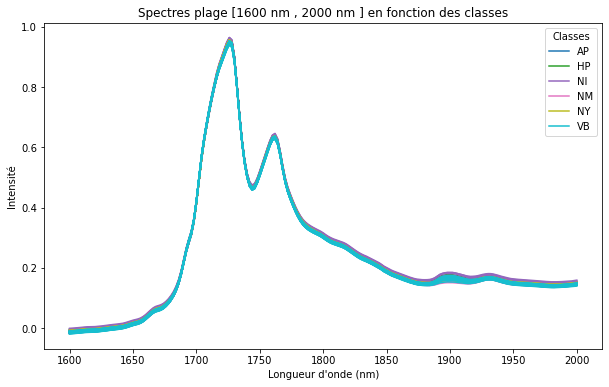

In [11]:

# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , filtered_intensities[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres plage [1600 nm , 2000 nm ] en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


# 3- Prétraitement des spectres et ACP.

Appliquez un prétraitement SNV, puis effectuer une ACP centrée non réduite des spectres transformées.

## Prétraitement SNV

In [12]:
# Appliquer la transformation SNV à chaque spectre dans le tableau
snv_spectra = np.apply_along_axis(snv_spectrum, axis=1, arr=filtered_intensities)
len(snv_spectra)

187

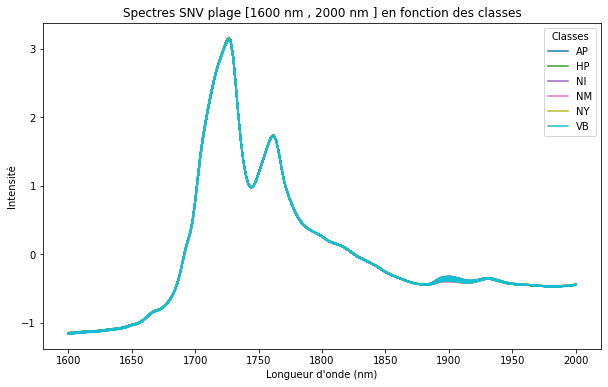

In [13]:

# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe)):
    label = classe[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , snv_spectra[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres SNV plage [1600 nm , 2000 nm ] en fonction des classes')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()


## ACP

In [14]:
pca = PCA( 10)
X = snv_spectra
X_mean = np.mean(X)
X_centered = X- X_mean
pca = pca.fit(X_centered)
explained_variance = pca.explained_variance_ratio_ ## variance expliqué par l'ACP
score = pca.transform(X_centered)
score

array([[-1.06122961e-02, -9.56630104e-03, -1.49361942e-02, ...,
         6.60026480e-03, -5.01221606e-03,  6.01150636e-04],
       [ 6.86285868e-03,  3.14894928e-02, -2.79985282e-02, ...,
         2.32116625e-03,  2.37557554e-04, -1.07080157e-03],
       [-7.44505729e-03,  2.99891341e-02, -2.44634531e-02, ...,
         7.18855850e-03, -4.83742610e-04, -7.92345538e-04],
       ...,
       [ 7.00987533e-02,  1.06467338e-01,  6.71858509e-03, ...,
        -6.11313686e-03,  3.83810535e-04, -1.10335249e-03],
       [ 4.94181108e-02,  8.56940102e-02, -2.64562380e-03, ...,
         2.00993791e-03, -2.95724549e-03,  6.15357396e-03],
       [ 2.20351045e-02,  9.13464947e-02,  7.07482705e-03, ...,
         3.22879223e-04, -3.08645968e-05, -4.04052014e-03]])

### diagramme de variance expliquée de l'ACP 

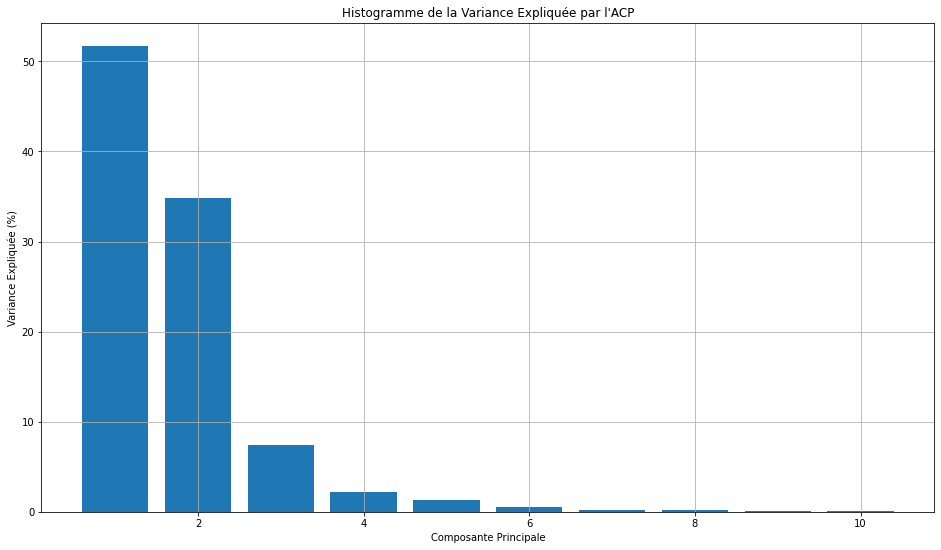

In [15]:
### visualisation de la variance expliquée par l'ACP
plt.figure(figsize=(16,9))
plt.bar(range(1, len(explained_variance) + 1), explained_variance*100, align='center')
plt.title('Histogramme de la Variance Expliquée par l\'ACP')
plt.xlabel('Composante Principale')
plt.ylabel('Variance Expliquée (%)')
plt.grid(True)
plt.show()

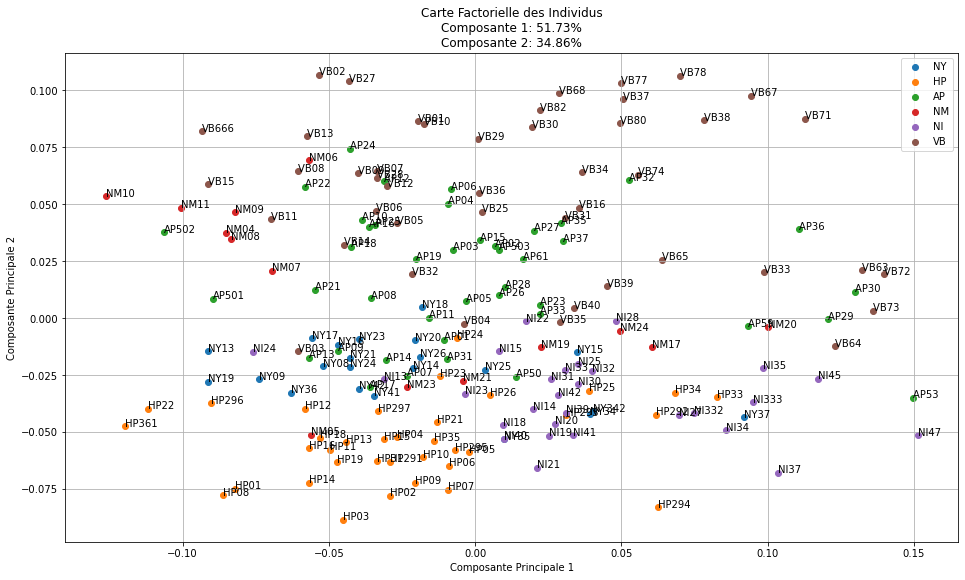

In [16]:
plot_acp_individuals(score=score, plan_indices=(0,1), individual_names=noms_individus, class_labels= classe , explained_variance = explained_variance )

# 4- Classification non supervisée.
Faites une classification hi ́erarchique des spectres SNV avec la m ́ethode Ward, et representez l’arbre hi ́erarchique r ́esultant. Coupez l’arbre hi ́erarchique en 6 groupes, calculez les spectres moyens de ces classes et repr ́esentez-les.

### classification hiérachique des spectres SNV avec la méthode ward

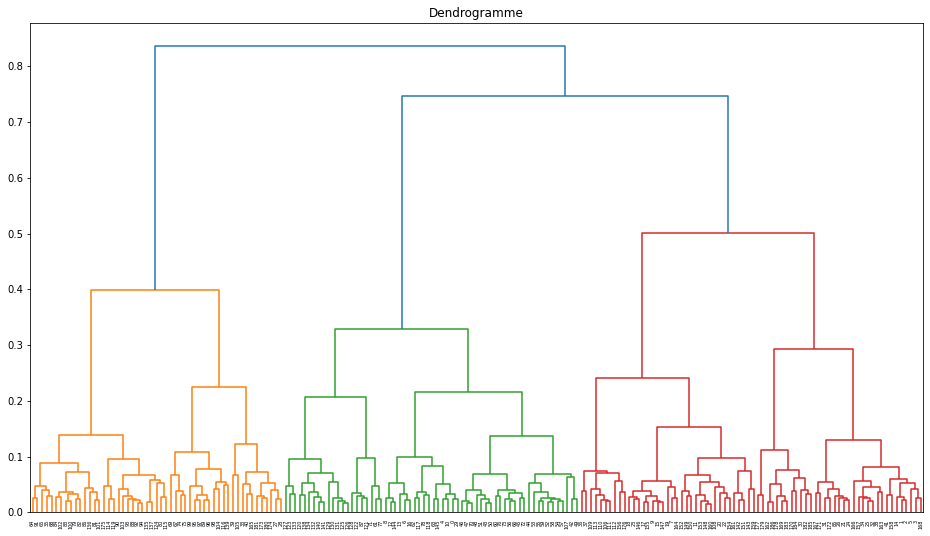

Cluster 1 indices: [1, 2, 3, 5, 14, 21, 24, 25, 26, 30, 31, 32, 34, 38, 41, 85, 157, 158, 162, 163, 166, 167, 168, 169, 170, 171, 172, 177, 178, 179, 182, 183, 184, 185, 186]
Cluster 2 indices: [7, 9, 11, 15, 17, 18, 19, 20, 22, 23, 36, 37, 106, 108, 109, 110, 111, 112, 113, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 159, 160, 161, 164, 176]
Cluster 3 indices: [27, 28, 33, 39, 40, 67, 69, 74, 75, 89, 95, 96, 97, 98, 99, 104, 105, 116, 139, 165, 173, 174, 180, 181]
Cluster 4 indices: [0, 4, 6, 8, 10, 12, 13, 16, 29, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 66, 70, 72, 73, 76, 78, 107, 117, 118, 144, 145]
Cluster 5 indices: [35, 64, 65, 68, 79, 80, 81, 82, 83, 84, 86, 88, 90, 91, 92, 93, 94, 100, 101, 102, 103, 114, 115, 119, 124, 135, 136, 137, 175]
Cluster 6 indices: [61, 71, 77, 87, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 138, 140, 141]


In [17]:
# initialisation pour avoir toujours les même resultats
np.random.seed(0) # on fixe la graine aléatoire
# Créer une instance du modèle de clustering hiérarchique
n_clusters = 6  # Nombre de clusters souhaité
hca= AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

# Ajuster le modèle aux données
cluster_labels = hca.fit_predict(X)

# Créer la matrice de liaison (dendrogramme)
Z = linkage(X, method='ward')

# Afficher le dendrogramme
plt.figure(figsize=(16, 9))
plt.title('Dendrogramme')
dendrogram(Z)
plt.show()

# Afficher les indices des individus pour chaque cluster
cluster_indices = [[] for _ in range(n_clusters)]

for i, label in enumerate(cluster_labels):
    cluster_indices[label].append(i)

# Afficher les indices des individus pour chaque cluster
for i, indices in enumerate(cluster_indices):
    print(f"Cluster {i+1} indices:", indices)



In [18]:
### calculons les spectres moyens et representonts les
spectres_moyen_hca = []
classe_spectres_moyen=[]
for i in range(len(cluster_indices)):
    spectres_moyen_hca.append((np.mean(X[cluster_indices[i]],axis=0)))

for i in range(len(spectres_moyen_hca)):
    classe_spectres_moyen.append(f"spectres moyen Cluster {i+1}")



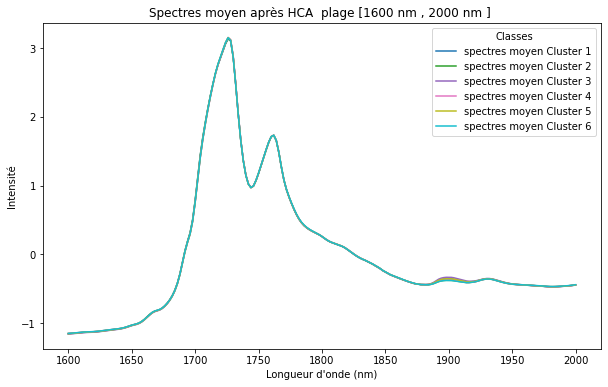

In [19]:
### visualisons les spectres moyens 
# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe_spectres_moyen)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(10, 6))
for i in range(len(classe_spectres_moyen)):
    label = classe_spectres_moyen[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , spectres_moyen_hca[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres moyen après HCA  plage [1600 nm , 2000 nm ] ')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()

In [20]:
labs_spectres_moyen=[]
classe_spectres_moyen =[]
for i in range(len(spectres_moyen_hca)):
    classe_spectres_moyen.append("spectres moyen Cluster")
for i in range(len(spectres_moyen_hca)):
    labs_spectres_moyen.append(f"spectres moyen Cluster {i+1}")
#labs_spectres_moyen=np.array(labs_spectres_moyen)
#classe_spectres_moyen =np.array(classe_spectres_moyen)
#### trouver les coordonnées des spectres moyens dans l'ACP
classe_hca = np.concatenate((classe,classe_spectres_moyen),axis=0)
noms_individus_hca = np.concatenate((noms_individus,labs_spectres_moyen),axis = 0)
cord_spectres_moyen_hca = pca.transform(spectres_moyen_hca)
score_cord_hca =np.concatenate((score,cord_spectres_moyen_hca),axis=0)

### plot


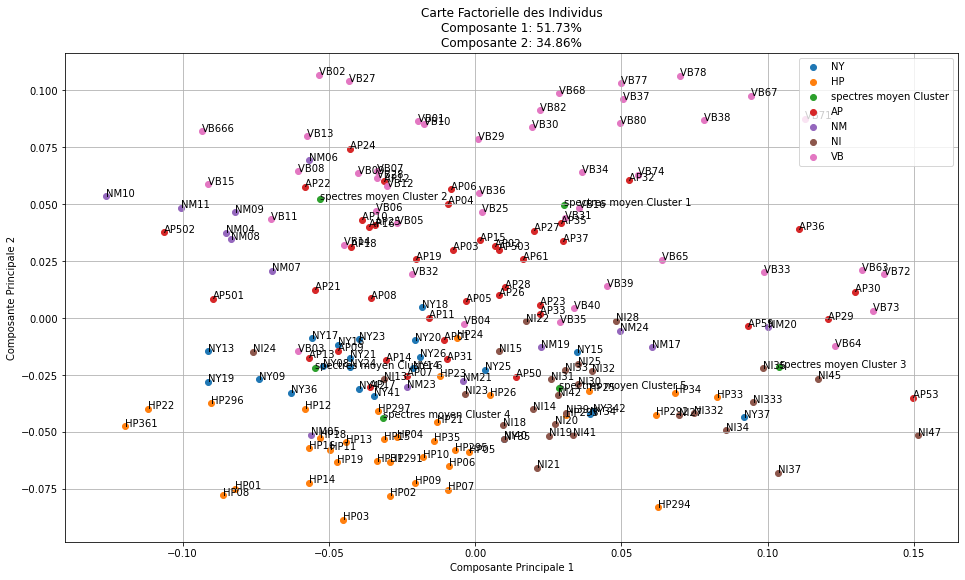

In [21]:
plot_acp_individuals(score=score_cord_hca,class_labels=classe_hca,explained_variance=explained_variance,individual_names=noms_individus_hca,plan_indices=(0,1))

# 5- Partitionnement K means

Faites un partitionnement de type k-means en 6 groupes, initialisé par la moyenne des 6 classes obtenues précedemment par coupure de l’arbre de CAH. Calculez les spectres moyens de ces 6 nouvelles classes issues de k-means et faites-en une représentation graphique.
réalisez 50 itérations

In [22]:
# initialisation pour avoir toujours les même resultats
np.random.seed(0) # on fixe la graine aléatoire
## initialisation des classes
class_center = np.array(spectres_moyen_hca)

## modèle Kmeans
kmeans = KMeans(n_clusters=n_clusters,init = class_center, max_iter= 50, random_state= 0)

## ajustez le modèle au données de spectres SNV  X
kmeans.fit(X)

### recupere les indices des clusters 
cluster_labels_kmeans = kmeans.labels_


/Users/douati/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [23]:
### recuperer les indices des différentes classes
cluster_indices_kmeans = [[] for _ in range(n_clusters)]
### créér une boucle pour recuperer les différents indices de chaque classe pour réaliser la moyenne des spectres de chaque classe obtenu après le Kmeans
for i, label in enumerate(cluster_labels_kmeans):
    cluster_indices_kmeans[label].append(i)

# Afficher les indices des individus pour chaque cluster
for i, indices in enumerate(cluster_indices_kmeans):
    print(f"Cluster {i+1} indices:", indices)

## recuperer les spectres moyens de chaque classe après la classification 




Cluster 1 indices: [1, 2, 3, 5, 14, 25, 30, 32, 34, 38, 41, 157, 158, 161, 162, 163, 166, 168, 169, 170, 171, 175, 177, 178, 179, 182, 183, 184, 185, 186]
Cluster 2 indices: [7, 9, 11, 15, 17, 18, 19, 20, 22, 23, 37, 106, 108, 109, 110, 111, 112, 113, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 159, 160, 164, 176]
Cluster 3 indices: [27, 28, 33, 39, 40, 74, 75, 95, 96, 97, 98, 99, 104, 105, 116, 139, 165, 173, 174, 180, 181]
Cluster 4 indices: [6, 8, 10, 12, 13, 16, 29, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 66, 70, 72, 73, 76, 107, 144]
Cluster 5 indices: [0, 4, 21, 24, 26, 31, 35, 62, 63, 64, 65, 67, 68, 69, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 100, 101, 102, 103, 114, 115, 117, 119, 124, 133, 135, 136, 137, 145, 167, 172]
Cluster 6 indices: [36, 61, 71, 77, 78, 87, 118, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 134, 138, 140, 141]


In [24]:
### calculons les spectres moyens et representonts les
spectres_moyen_kmeans = []
classe_spectres_moyen_kmeans =[]
for i in range(len(cluster_indices_kmeans)):
    spectres_moyen_kmeans.append((np.mean(X[cluster_indices_kmeans[i]],axis=0)))

for i in range(len(spectres_moyen_kmeans)):
    classe_spectres_moyen_kmeans.append(f"spectres moyen Cluster {i+1}")



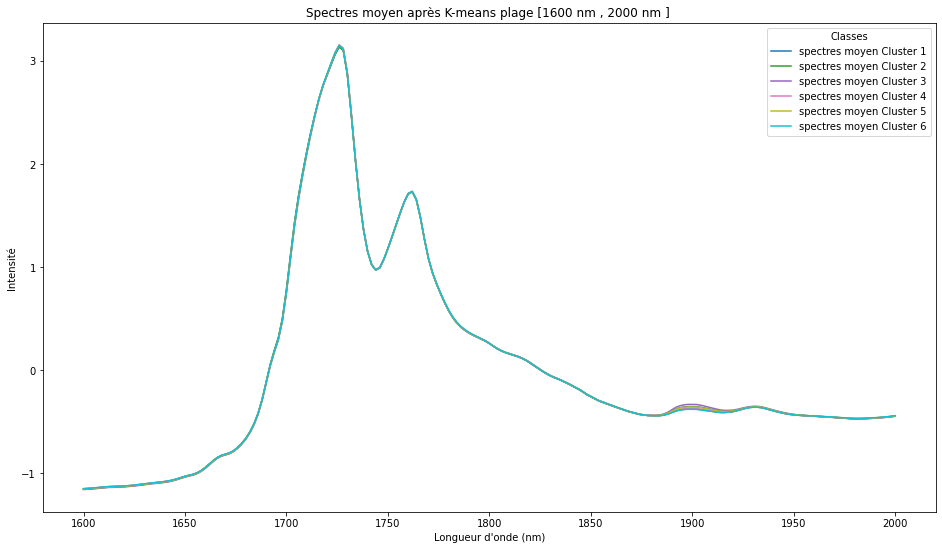

In [25]:
### visualisons les spectres moyens 
# Créer un dictionnaire pour mapper les couleurs aux labels
unique_labels = np.unique(classe_spectres_moyen_kmeans)
color_map = plt.cm.get_cmap('tab10', len(unique_labels))  # Utiliser la colormap 'tab10'

# Tracer les spectres avec les couleurs basées sur les labels
plt.figure(figsize=(16, 9))
for i in range(len(classe_spectres_moyen_kmeans)):
    label = classe_spectres_moyen_kmeans[i]
    color = color_map(unique_labels.tolist().index(label))  # Associer la couleur basée sur l'index du label unique
    plt.plot(filtered_wavelength , spectres_moyen_kmeans[i], label=label, color=color)

plt.xlabel('Longueur d\'onde (nm)')
plt.ylabel('Intensité')
plt.title('Spectres moyen après K-means plage [1600 nm , 2000 nm ] ')

# Créer une légende avec des couleurs basées sur les labels uniques
handles = [plt.Line2D([0], [0], color=color_map(i), label=label) for i, label in enumerate(unique_labels)]
plt.legend(handles=handles, title='Classes', loc='upper right')

# Afficher le graphique
plt.show()

# 6- Représentation des observations par leur groupe issu de k-means.
Representez les  echantillons sur les scores des deux premieres composantes principales de l’ACP obtenue a l’ etape 3 en les coloriant par leur classe d’appartenance.

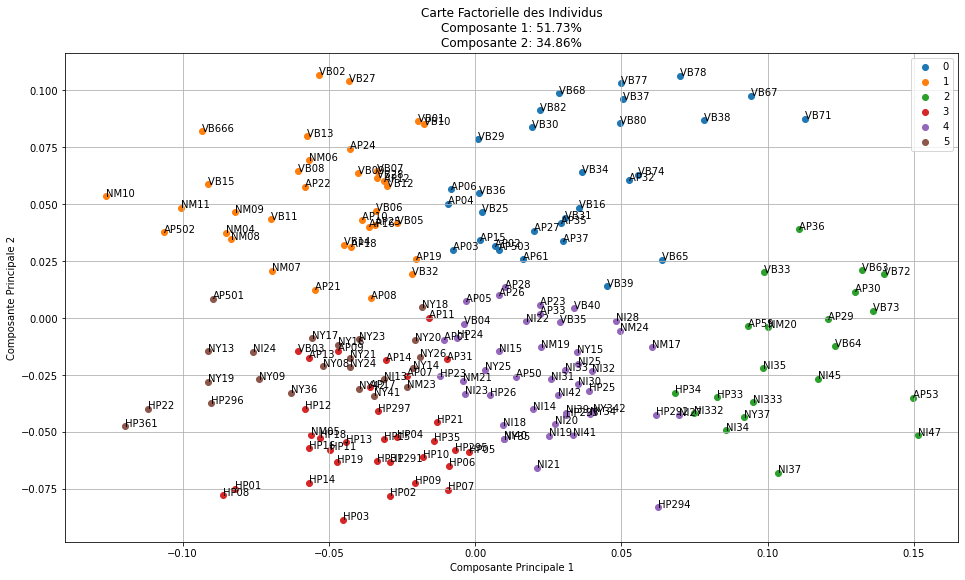

In [26]:
labels_kmeans = kmeans.labels_
plot_acp_individuals(score =score , plan_indices=(0,1), individual_names= noms_individus, class_labels= labels_kmeans, explained_variance=explained_variance)

# 7- Comparaison avec l’acide linoleique.
Visualiser le fichier ags.tab et noter à quelle colonne correspond l’acide linol ́eique.
Faites une representation de type boxplot de la teneur en acide linoleique (C18:2 )par classe d’appartenance. Examinez le lien entre la teneur en acide linoĺeique des  echantillons et la position de ceux-ci sur le premier plan de l’ACP.

In [27]:
infos_analyses.head()

,Unnamed: 0,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
0,AP01,13.22,0.10,1.01,0.06,0.11,2.03,71.06,2.61,8.37,0.69,0.34,0.24,0.11,0.05,0.65
1,AP02,14.32,0.12,1.06,0.09,0.16,2.34,67.34,2.51,10.74,0.55,0.38,0.22,0.11,0.05,0.59
2,AP03,14.00,0.12,1.06,0.10,0.17,2.24,68.13,2.56,10.33,0.56,0.36,0.21,0.11,0.05,0.62
3,AP04,13.84,0.11,0.90,0.08,0.14,2.38,67.67,2.29,11.28,0.57,0.37,0.20,0.11,0.06,0.58
4,AP05,13.69,0.12,1.03,0.12,0.21,2.40,68.92,2.51,9.69,0.55,0.38,0.21,0.12,0.05,0.60


la colonne de l'acide linoléique est la 10 éme mais la 9 éme python (lol)

In [28]:
infos_analyses.describe()

,C16:0,C16:1w9,C16:1w7,C17:0,C17:1w8,C18:0,C18:1w9,C18:1w7,C18:2w6,C18:3w3,C20:0,C20:1w9,C22:0,C24:0,Squalene
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,12.096578,0.120963,0.860898,0.095829,0.171123,2.350267,72.021765,2.285829,8.588342,0.595080,0.386150,0.262299,0.114652,0.051497,0.699786
std,2.185867,0.018755,0.293332,0.063540,0.092424,0.253840,5.152447,0.412985,2.559711,0.085234,0.036295,0.044074,0.011513,0.009995,0.142467
min,7.380000,0.080000,0.310000,0.030000,0.050000,1.640000,62.070000,1.280000,4.920000,0.460000,0.320000,0.190000,0.090000,0.020000,0.360000
25%,10.650000,0.110000,0.630000,0.050000,0.100000,2.180000,67.530000,2.095000,6.300000,0.550000,0.360000,0.225000,0.110000,0.050000,0.610000
50%,12.450000,0.120000,0.910000,0.080000,0.140000,2.380000,72.820000,2.390000,7.840000,0.580000,0.380000,0.250000,0.110000,0.050000,0.720000
75%,13.900000,0.135000,1.090000,0.130000,0.235000,2.570000,75.500000,2.560000,10.720000,0.620000,0.415000,0.305000,0.120000,0.060000,0.800000
max,16.200000,0.170000,1.760000,0.700000,0.400000,2.850000,81.490000,3.410000,14.050000,0.960000,0.460000,0.370000,0.140000,0.070000,0.990000


In [29]:
qte_acide_linoleique_by_kmeans = []
for i in range (len(cluster_indices_kmeans)):
    qte_acide_linoleique_by_kmeans.append(qte_acide_linoleique[cluster_indices_kmeans[i]])
qte_acide_linoleique_by_kmeans = np.array(qte_acide_linoleique_by_kmeans)

/var/folders/pg/vhdrv4jj46dbx6y69j09508m0000gn/T/ipykernel_52399/2777177238.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  qte_acide_linoleique_by_kmeans = np.array(qte_acide_linoleique_by_kmeans)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f81483d9940>,
 'caps': [<matplotlib.lines.Line2D at 0x7f81483d9280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f81483d9880>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8148228be0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8148228fa0>,
 'means': []}

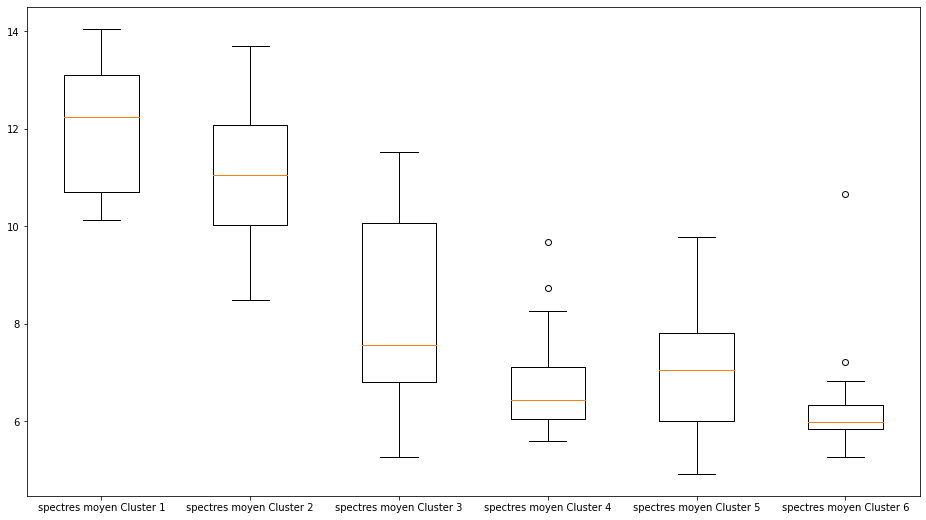

In [30]:
plt.figure(figsize=(16,9))
plt.boxplot(x=qte_acide_linoleique_by_kmeans,labels=classe_spectres_moyen_kmeans)


Fort lien avec la CP 2 realisons une representation avec en y l'acide linoléique et x les cordonnée en CP2

Text(0.5, 1.0, ' Reprensentation de qte_acide_liboleique = f (CP 2)')

<Figure size 1152x648 with 0 Axes>

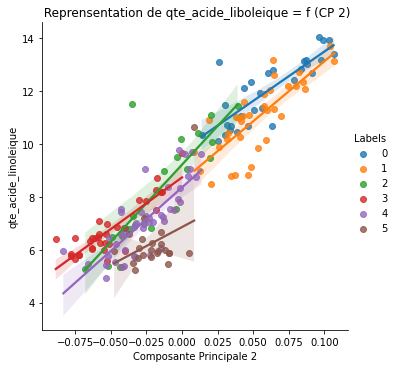

In [55]:

cp_2 = score[:,1]

# Créez un dictionnaire avec les données
data = {
    'Labels': labels_kmeans,
    'Axe X': cp_2,
    'Axe Y': qte_acide_linoleique
}

# Créez un DataFrame à partir du dictionnaire
data_nuagepoint = pd.DataFrame(data)

# Affichez les premières lignes du DataFrame
data_nuagepoint.head()
plt.figure(figsize=(16,9))

sns.lmplot(data=data_nuagepoint,x= 'Axe X' , y = 'Axe Y', hue= 'Labels')

plt.xlabel('Composante Principale 2')
plt.ylabel('qte_acide_linoleique')
plt.title(' Reprensentation de qte_acide_liboleique = f (CP 2)')

### Observation :
on remarque l'evolution de la quantité d'acide linoléique depend fortement de la CP 2 en plus la séparation Kmeans a été réalisé en prenant cela en compte 